# Generalized Orthogonal Least-Squares
https://arxiv.org/pdf/1602.06916.pdf

In [1]:
%pylab inline
import seaborn
seaborn.set_context('talk')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, 'build')
import _gols

In [43]:
def gols_solve(dictionary, y, sparsity, L):
    import bisect
    import numpy
    '''
    dictionary is a n x m matrix
    looking for y = A * x with x super-sparse
    '''
    A = dictionary
    k = sparsity
    n, m = A.shape
    Port = numpy.eye(n)
    S = set()
    I = range(m)
    for i in range(0, min(k, n / L)):
        Porta = numpy.array([Port.dot(A[:, j]) for j in I])
        Porta = numpy.divide(Porta, numpy.linalg.norm(Porta, axis=1)[:,None])
        gamma = numpy.array([abs(y.dot(porta)) for porta in Porta])
        L_largest = gamma.argsort()[-L:]
        largest_indices = [I[j] for j in L_largest]
        [S.add(I[j]) for j in L_largest]
        [I.pop(bisect.bisect_left(I, j)) for j in largest_indices]
        D = Port
        for j in largest_indices:
            Da = D.dot(A[:, j])
            d = Da / numpy.linalg.norm(Da)
            D = D - numpy.outer(d, d)
        Port = D
    As = numpy.array([A[:, j] for j in S]).T
    xs, _, _, _ = numpy.linalg.lstsq(As, y)
    return S, xs

In [62]:
x = numpy.linspace(0, 1, 512)
A = []
numpy.random.seed(0)
for i in range(200):
    sigma, pos = numpy.random.random(2)
    A.append(numpy.exp(-(x-pos)**2/(2*sigma**2)))
A = numpy.array(A).T
# A = A.astype(numpy.float32)
y = numpy.sin(2 * numpy.pi * x) + 0.5 * numpy.sin(3 * numpy.pi * x)

In [71]:
%%time
xcpu = []
ycpu = []
for sparsity in range(1, 20):
    As, ys = gols_solve(A, y, sparsity, 7)
    yre = numpy.array([A[:,j] for j in As]).T.dot(ys)
    ycpu.append(numpy.linalg.norm(yre - y))
    xcpu.append(sparsity)

CPU times: user 4.58 s, sys: 7.99 s, total: 12.6 s
Wall time: 1.71 s


In [72]:
%%time
xcpu2 = []
ycpu2 = []
for sparsity in range(1, 20):
    As, ys = gols_solve_broken(A, y, sparsity, 7)
    yre = numpy.array([A[:,j] for j in As]).T.dot(ys)
    ycpu2.append(numpy.linalg.norm(yre - y))
    xcpu2.append(sparsity)

CPU times: user 4.45 s, sys: 7.1 s, total: 11.6 s
Wall time: 1.51 s


In [73]:
%%time
xerror = []
yerror = []
for sparsity in range(1, 20):
    cols, xsgpu = _gols.gols_solve(A.T, y, sparsity, 3, True)
    As = numpy.array([A[:,j] for j in cols]).T
    xsgpu, _,_,_ = numpy.linalg.lstsq(As, y)
    yre = As.dot(xsgpu)
#     print xs[:6], xsgpu[:6]
    yerror.append(numpy.linalg.norm(yre - y))
    xerror.append(sparsity)
    
with open('kahan-data.pkl', 'r') as f:
    import pickle
    _, _, xx, yy = pickle.loads(f.read())



CPU times: user 172 ms, sys: 580 ms, total: 752 ms
Wall time: 106 ms


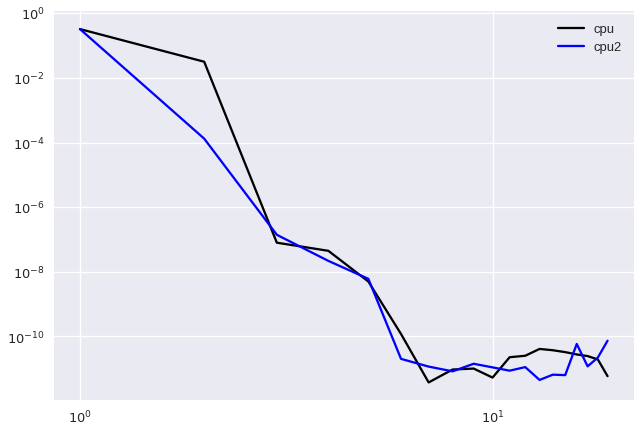

In [74]:
loglog(xcpu, ycpu, label='cpu', color='black')
loglog(xcpu2, ycpu2, label='cpu2', color='blue')
# loglog(xerror, yerror, label='no kahan')

# loglog(xx, yy, '-o',label='kahan' )
legend()

In [75]:
%time
xerror3 = []
yerror3 = []
for sparsity in range(1, 20):
    As, ys = gols_solve(A, y, sparsity, 4)
    yre = numpy.array([A[:,j] for j in As]).T.dot(ys)
    yerror3.append(numpy.linalg.norm(yre - y))
    xerror3.append(sparsity)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


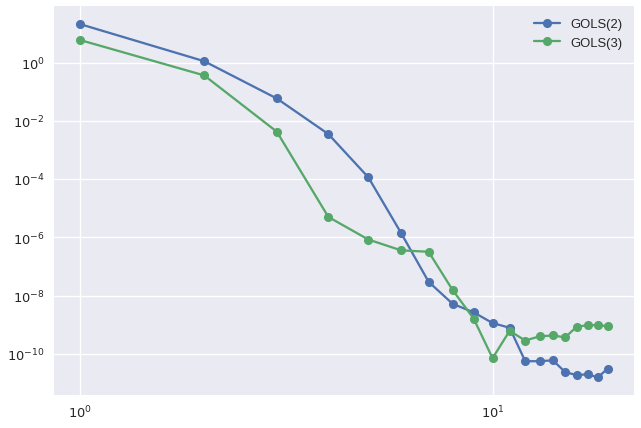

In [51]:
loglog(xerror, yerror, '-o', label='GOLS(2)')
loglog(xerror3, yerror3, '-o', label='GOLS(3)')
legend()

In [52]:
%time
xerror = []
yerror = []
for sparsity in range(1, 50):
    cols = _gols.gols_solve(A.T, y, sparsity, 2)
    As = numpy.array([A[:,j] for j in cols]).T
    xs, _,_,_ = numpy.linalg.lstsq(As, y)
    
    yre = As.dot(xs)
#     As, ys = gols_solve(A, y, sparsity, 3)
#     yre = numpy.array([A[:,j] for j in As]).T.dot(ys)
    yerror.append(numpy.linalg.norm(yre - y))
    xerror.append(sparsity)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


TypeError: gols_solve(): incompatible function arguments. The following argument types are supported:
    1. (arg0: numpy.ndarray[float32], arg1: numpy.ndarray[float32], arg2: int, arg3: int, arg4: bool) -> Tuple[List[int], List[float]]

Invoked with: array([[  4.27796698e-001,   4.28293056e-001,   4.28789649e-001, ...,
          8.74821070e-001,   8.74418085e-001,   8.74014593e-001],
       [  6.64589554e-001,   6.65076421e-001,   6.65563206e-001, ...,
          7.52896063e-001,   7.52436215e-001,   7.51976155e-001],
       [  3.12807712e-001,   3.13357904e-001,   3.13908646e-001, ...,
          7.06532653e-001,   7.05853426e-001,   7.05173915e-001],
       ..., 
       [  9.13980410e-181,   1.39418118e-180,   2.12621953e-180, ...,
          4.85442927e-001,   4.76905988e-001,   4.68418385e-001],
       [  6.04246949e-001,   6.05080729e-001,   6.05914514e-001, ...,
          1.95252561e-001,   1.94767837e-001,   1.94283949e-001],
       [  1.13651944e-028,   1.59507144e-028,   2.23663270e-028, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000]]), array([  0.00000000e+00,   5.37154263e-03,   1.07430075e-02, ...,
        -1.53475668e-03,  -7.67368398e-04,  -6.12323400e-17]), 1, 2

In [ ]:
## %time
xerror3 = []
yerror3 = []
for sparsity in range(1, 20):
    cols = _gols.gols_solve(A.T, y, sparsity, 4)
    As = numpy.array([A[:,j] for j in cols]).T
    xs, _,_,_ = numpy.linalg.lstsq(As, y)
    
    yre = As.dot(xs)
#     As, ys = gols_solve(A, y, sparsity, 3)
#     yre = numpy.array([A[:,j] for j in As]).T.dot(ys)
    yerror3.append(numpy.linalg.norm(yre - y))
    xerror3.append(sparsity)

In [ ]:
loglog(xerror, yerror, '-o', label='GOLS(2)')
loglog(xerror3, yerror3, '-o', label='GOLS(3)')
legend()

In [ ]:
loglog(xerror, yerror, '-o', label='GOLS(2)')
loglog(xerror3, yerror3, '-o', label='GOLS(3)')
legend()

In [ ]:
# import pickle
# with open('kahan-data.pkl', 'w') as f:
#     f.write(pickle.dumps((xerror, yerror, xerror3, yerror3)))